# Bolometry in LHD

This notebook describes how the bolometry system in LHD is configured by showing the lines of sights of resistive bolometers and the field of viewcone of InfraRed Video Bolometer (IRVB) cameras in the Large Helical Device (LHD).

In [1]:
import numpy as np
import plotly.io as pio
from plotly import graph_objects as go
from raysect.core.math import Point3D, rotate_z
from raysect.optical import Ray, World
from raysect.primitive import Mesh
from rich import print

from cherab.lhd.machine import load_pfc_mesh
from cherab.lhd.observer.bolometer import load_irvb, load_resistive
from cherab.lhd.tools.fetch import fetch_file

# Comment out the following line to view the plot interactively
pio.renderers.default = "jpg"

## Load bolometers and show modeled IRVB


Firstly, let us create root scene-graph node called `world`.


In [2]:
world = World()

And, we will load each type of bolometers (resistive bolometers and IRVB) into the scene.


In [3]:
bolo_resistives = []
for port, model in zip(["6.5L", "6.5L", "8O"], ["I", "O", ""], strict=True):
    rb = load_resistive(port=port, model_variant=model, parent=world)
    bolo_resistives.append(rb)

print(bolo_resistives)

[
    <cherab.tools.observers.bolometry.BolometerCamera object at 0x30e8928d0>,
    <cherab.tools.observers.bolometry.BolometerCamera object at 0x30e892e50>,
    <cherab.tools.observers.bolometry.BolometerCamera object at 0x30e892fd0>
]

In [4]:
bolo_irvbs = []
for port, flange in zip(["6.5U", "6.5L"], ["CC01_04", "BC02"], strict=True):
    irvb = load_irvb(port=port, flange=flange, parent=world)
    bolo_irvbs.append(irvb)

print(bolo_irvbs)

[IRVBCamera(name=IRVB-6.5U-CC01_04), IRVBCamera(name=IRVB-6.5L-BC02)]

Let us show the modeled IRVB in 3-D space with plotly.


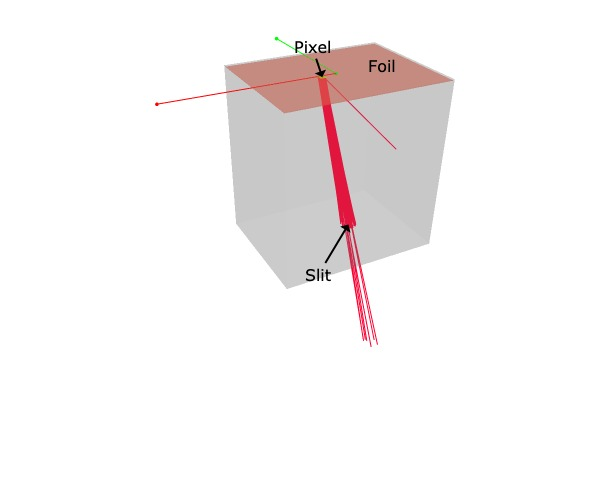

In [5]:
irvb = bolo_irvbs[0]
fig = go.Figure()
nx, ny = (10, 10)
fig = irvb.plot_bolometer_geometry(fig=fig, plot_pixel_rays={"pixel": (nx, ny), "num_rays": 50})

# Annotation of slit
x, y, z = irvb.slit.centre_point
text_slit = dict(
    x=x,
    y=y,
    z=z,
    text="Slit",
    textangle=0,
    ax=-30,
    ay=50,
    font=dict(color="black", size=16),
    arrowcolor="black",
)

# Annotation of foil
foil_detector = irvb.foil_detector
x, y, z = Point3D(-foil_detector.width * 0.3, 0, 0).transform(foil_detector.to_root())
text_foil = dict(x=x, y=y, z=z, text="Foil", font=dict(color="black", size=16), ax=0, ay=0)

# Annotation of pixel
pixels = irvb.pixels_as_foils
x, y, z = pixels[nx, ny].centre_point
text_pixel = dict(
    x=x,
    y=y,
    z=z,
    text="Pixel",
    font=dict(color="black", size=16),
    arrowcolor="black",
)

# Update scene
fig.update_layout(
    width=600,
    height=500,
    scene_annotations=[text_slit, text_foil, text_pixel],
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
)
fig.show()

## Show bolometry system in 3-D space with plasma

Here we show the bolometry system in 3-D space by plotting the lines of sight of resistive bolometers and view cones of IRVBs.
A plasma volume and some plasma facing components are also shown to give a sense of the scale of the system.


In [6]:
# Load LHD PFCs and plasma meshes
meshes = load_pfc_mesh(world)
plasma = Mesh.from_file(fetch_file("machine/plasma_quarter.rsm"), parent=world, name="plasma")

Output()

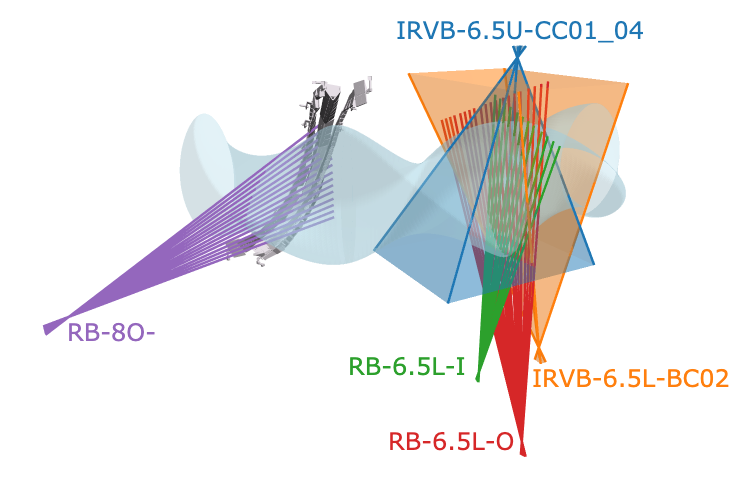

In [7]:
fig = go.Figure()

text_annotations = []
# -----------------
# === IRVB FoV ====
# -----------------
for camera, color in zip(bolo_irvbs, ("#1f77b4", "#ff7f0e"), strict=True):
    los = camera.sightline_rays
    px, py = los.shape
    lines = []
    for i, j in [(0, 0), (px - 1, 0), (px - 1, py - 1), (0, py - 1)]:
        ray = los[i][j]
        lines.append(np.array([[*ray.origin], [*ray.point_on(20)]]))
        fig.add_trace(
            go.Scatter3d(
                mode="lines",
                x=lines[-1][:, 0],
                y=lines[-1][:, 1],
                z=lines[-1][:, 2],
                line=dict(color=color, width=5),
                showlegend=False,
            )
        )
    slit_centre = camera.slit.centre_point
    for k, is_showlegend in enumerate([False, True]):
        xyz = np.asanyarray([[*[line[k, i] for line in lines], slit_centre[i]] for i in range(3)])
        fig.add_trace(
            go.Mesh3d(
                x=xyz[0, :],
                y=xyz[1, :],
                z=xyz[2, :],
                i=[1, 1, 0, 0, 3, 1],
                j=[3, 2, 4, 3, 2, 4],
                k=[0, 3, 1, 4, 4, 2],
                color=color,
                opacity=0.3,
                flatshading=True,
                name=camera.name,
                showlegend=is_showlegend,
            )
        )
    # Annotation
    x, y, z = Point3D(0, 0, 0).transform(camera.foil_detector.to_root())
    text_annotations.append(
        dict(
            x=x,
            y=y,
            z=z,
            text=f"{camera.name}",
            font=dict(color=color, size=24),
            showarrow=False,
            xanchor="left" if "6.5L" in camera.name else "center",
            yanchor="bottom" if "6.5U" in camera.name else "top",
            xshift=-10 if "6.5L" in camera.name else 0,
        )
    )


# --------------
# === RB LoS ===
# --------------
for camera, color, length in zip(
    bolo_resistives, ("#2ca02c", "#d62728", "#9467bd"), (23, 23, 22), strict=True
):
    is_showlegend = True
    for foil in camera.foil_detectors:
        ray = Ray(foil.centre_point, foil.sightline_vector)
        line = np.array([[*ray.origin], [*ray.point_on(length)]])
        fig.add_trace(
            go.Scatter3d(
                mode="lines",
                x=line[:, 0],
                y=line[:, 1],
                z=line[:, 2],
                line=dict(color=color, width=5),
                name=camera.name,
                text=foil.name,
                showlegend=is_showlegend,
            )
        )
        is_showlegend = False

    # Annotation
    x, y, z = foil.centre_point
    text_annotations.append(
        dict(
            x=x,
            y=y,
            z=z,
            text=f"{camera.name}",
            font=dict(color=color, size=24),
            showarrow=False,
            xanchor="right" if "6.5" in camera.name else "left",
            yanchor="bottom" if "6.5" in camera.name else "top",
            xshift=-10 if "6.5" in camera.name else 20,
            yshift=20 if "8O" in camera.name else 0,
        )
    )

# ---------------------
# === Plasma volume ===
# ---------------------
x, y, z = plasma.data.vertices.T
index_i, index_j, index_k = plasma.data.triangles.T
plasma_mesh = go.Mesh3d(
    x=x,
    y=y,
    z=z,
    i=index_i,
    j=index_j,
    k=index_k,
    flatshading=False,
    color="#ADD8E6",  # Light blue color
    opacity=0.2,
    name="Plasma",
    showscale=False,
    hoverinfo="skip",
    showlegend=True,
)
fig.add_trace(plasma_mesh)

# --------------------
# === LHD Divertor ===
# --------------------
lighting_effects = dict(
    ambient=0.18, diffuse=1, fresnel=0.1, specular=0, roughness=0.1, facenormalsepsilon=0
)
mesh = meshes["Divertor"][0]
angle = 36 * 5
rotation = np.array(
    [
        [*Point3D(1, 0, 0).transform(rotate_z(angle))],
        [*Point3D(0, 1, 0).transform(rotate_z(angle))],
        [*Point3D(0, 0, 1).transform(rotate_z(angle))],
    ]
)
x, y, z = rotation @ mesh.data.vertices.T
index_i, index_j, index_k = mesh.data.triangles.T
divertor_mesh = go.Mesh3d(
    x=x,
    y=y,
    z=z,
    i=index_i,
    j=index_j,
    k=index_k,
    colorscale=[[0, "#e5dee5"], [1, "#e5dee5"]],
    opacity=1.0,
    flatshading=True,
    intensity=z,
    name="Divertor",
    showscale=False,
    hoverinfo="skip",
    lighting=lighting_effects,
    lightposition=dict(x=3000, y=3000, z=10000),
    showlegend=False,
)
fig.add_trace(divertor_mesh)

# ----------------
# === Port 6.5 ===
# ----------------
# # Load Port meshes
# port65u = Mesh.from_file(fetch_file("machine/port_65u.rsm"), parent=world, name="port_6.5U")
# port65l = Mesh.from_file(fetch_file("machine/port_65l.rsm"), parent=world, name="port_6.5L")
#
# angle = 36 * 4
# rotation = np.array(
#     [
#         [*Point3D(1, 0, 0).transform(rotate_z(angle))],
#         [*Point3D(0, 1, 0).transform(rotate_z(angle))],
#         [*Point3D(0, 0, 1).transform(rotate_z(angle))],
#     ]
# )
# for mesh in [port65u, port65l]:
#     x, y, z = rotation @ mesh.data.vertices.T
#     index_i, index_j, index_k = mesh.data.triangles.T
#     port_mesh = go.Mesh3d(
#         x=x,
#         y=y,
#         z=z,
#         i=index_i,
#         j=index_j,
#         k=index_k,
#         colorscale=[[0, "#e5dee5"], [1, "#e5dee5"]],
#         opacity=1.0,
#         flatshading=True,
#         intensity=z,
#         name=mesh.name,
#         showscale=False,
#         hoverinfo="skip",
#         lighting=lighting_effects,
#         lightposition=dict(x=3000, y=3000, z=10000),
#         showlegend=False,
#     )
#     fig.add_trace(port_mesh)

# Update visibility
fig.update_scenes(
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False,
)
camera = dict(
    up=dict(x=0, y=0, z=1), center=dict(x=0, y=-0.02, z=0.04), eye=dict(x=-0.8, y=-0.8, z=0.5)
)
fig.update_layout(
    width=740,
    height=500,
    scene_camera=camera,
    showlegend=False,
    scene_aspectmode="data",
    scene_annotations=text_annotations,
    margin=dict(r=10, l=0, b=10, t=10),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
)
fig.show(renderer="png")

Export the figure as several image files:


In [8]:
# fig.write_image("bolometer_config.pdf", scale=3)
# fig.write_image("bolometer_config.png", scale=1)

## Compare flange variant of IRVB 6.5L

Let us compare the flange variant of IRVB 6.5L with the default one (BC02 vs AL01).


In [9]:
irvbs = []
for port, flange in zip(["6.5L", "6.5L"], ["BC02", "AL01"], strict=True):
    irvb = load_irvb(port=port, flange=flange, parent=world)
    irvbs.append(irvb)

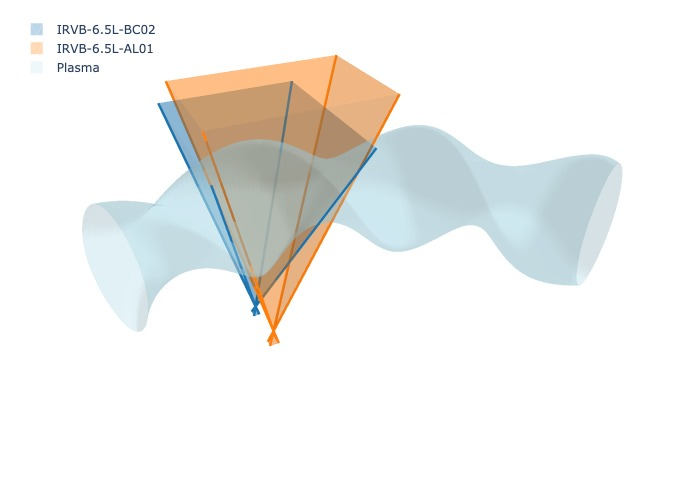

In [10]:
fig = go.Figure()

# -----------------
# === IRVB FoV ====
# -----------------
for camera, color, length in zip(irvbs, ("#1f77b4", "#ff7f0e"), (20, 18), strict=True):
    los = camera.sightline_rays
    px, py = los.shape
    lines = []
    for i, j in [(0, 0), (px - 1, 0), (px - 1, py - 1), (0, py - 1)]:
        ray = los[i][j]
        lines.append(np.array([[*ray.origin], [*ray.point_on(length)]]))
        fig.add_trace(
            go.Scatter3d(
                mode="lines",
                x=lines[-1][:, 0],
                y=lines[-1][:, 1],
                z=lines[-1][:, 2],
                line=dict(color=color, width=5),
                showlegend=False,
            )
        )
    slit_centre = camera.slit.centre_point
    for k, is_showlegend in enumerate([False, True]):
        xyz = np.asanyarray([[*[line[k, i] for line in lines], slit_centre[i]] for i in range(3)])
        fig.add_trace(
            go.Mesh3d(
                x=xyz[0, :],
                y=xyz[1, :],
                z=xyz[2, :],
                i=[1, 1, 0, 0, 3, 1],
                j=[3, 2, 4, 3, 2, 4],
                k=[0, 3, 1, 4, 4, 2],
                color=color,
                opacity=0.3,
                flatshading=True,
                name=camera.name,
                showlegend=is_showlegend,
            )
        )

# ---------------------
# === Plasma volume ===
# ---------------------
x, y, z = plasma.data.vertices.T
index_i, index_j, index_k = plasma.data.triangles.T
plasma_mesh = go.Mesh3d(
    x=x,
    y=y,
    z=z,
    i=index_i,
    j=index_j,
    k=index_k,
    flatshading=False,
    color="#ADD8E6",  # Light blue color
    opacity=0.2,
    name="Plasma",
    showscale=False,
    hoverinfo="skip",
    showlegend=True,
)

fig.add_trace(plasma_mesh)

# Update visibility
fig.update_scenes(
    xaxis_visible=False,
    yaxis_visible=False,
    zaxis_visible=False,
)
camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=0, z=0), eye=dict(x=0.9, y=0.9, z=0.9))
fig.update_layout(
    width=700,
    height=500,
    scene_camera=camera,
    scene_aspectmode="data",
    margin=dict(r=10, l=10, b=10, t=10),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
)